In [1]:
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt


# Mimega

In [2]:

# === PARAMETRI ===
root_folder = "data/mimega"
num_strips = 360


In [3]:

# === PERCORSI DI SALVATAGGIO ===
signal_x_path = os.path.join(root_folder, "signal_x.npy")
signal_y_path = os.path.join(root_folder, "signal_y.npy")
noise_x_path = os.path.join(root_folder, "noise_x.npy")
noise_y_path = os.path.join(root_folder, "noise_y.npy")


In [4]:

# === FUNZIONE DI ESTRAZIONE X/Y ===
def estrai_eventi_xy(filepath):
    with uproot.open(filepath) as file:
        tree = file["TBtree;1"]
        df = tree.arrays(library="pd")

    hit_index = df["hit_index"].to_list()
    hit_q = df["hit_q"].to_list()
    hit_issecondcoord = df["hit_issecondcoord"].to_list()

    xy_x, xy_y = [], []

    for indexes, charges, coords in zip(hit_index, hit_q, hit_issecondcoord):
        for idxs, qs, isys in zip(indexes, charges, coords):
            event_x = np.zeros(num_strips)
            event_y = np.zeros(num_strips)
            for idx, q, isy in zip(idxs, qs, isys):
                if isy == 0:
                    event_x[idx] = q
                else:
                    event_y[idx] = q
            xy_x.append(event_x)
            xy_y.append(event_y)

    return np.array(xy_x, dtype=np.float32), np.array(xy_y, dtype=np.float32)


In [5]:

# === ESTRAZIONE E SALVATAGGIO EVENTI DI SEGNALE ===
signal_file = os.path.join(root_folder, "external.root")
signal_x, signal_y = estrai_eventi_xy(signal_file)
np.save(signal_x_path, signal_x)
np.save(signal_y_path, signal_y)
print(f"[✔] Eventi di segnale salvati: {len(signal_x)} esempi")


[✔] Eventi di segnale salvati: 6761 esempi


In [6]:

# === ESTRAZIONE E SALVATAGGIO EVENTI DI RUMORE ===
noise_file = os.path.join(root_folder, "internal.root")
noise_x, noise_y = estrai_eventi_xy(noise_file)
np.save(noise_x_path, noise_x)
np.save(noise_y_path, noise_y)
print(f"[✔] Eventi di rumore salvati: {len(noise_x)} esempi")


[✔] Eventi di rumore salvati: 8219 esempi


In [7]:

# === PLOT DI UN ESEMPIO DI SEGNALE ===
def plot_event(x_array, y_array, idx=0):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.bar(range(num_strips), x_array[idx], color="blue", alpha=0.6)
    plt.xlabel("Strip")
    plt.ylabel("Carica")
    plt.title("Segnale - X coord")

    plt.subplot(1, 2, 2)
    plt.bar(range(num_strips), y_array[idx], color="red", alpha=0.6)
    plt.xlabel("Strip")
    plt.ylabel("Carica")
    plt.title("Segnale - Y coord")

    plt.tight_layout()
    plt.show()


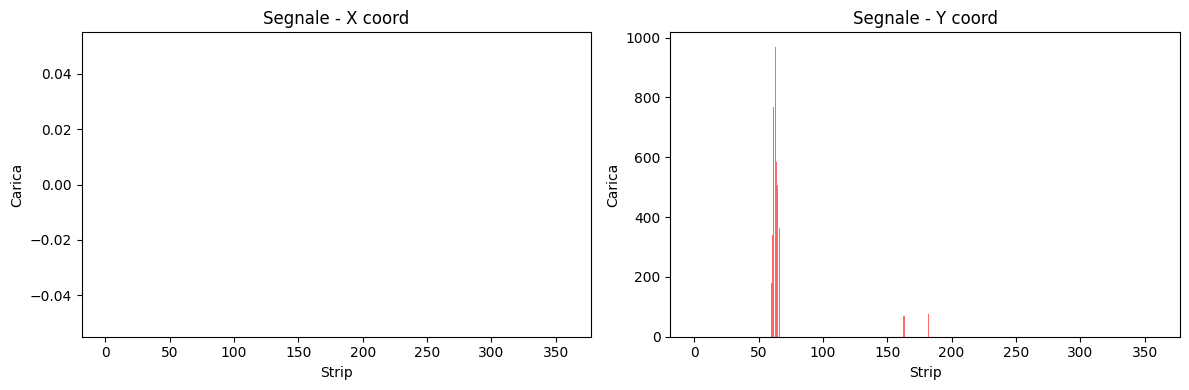

In [8]:

# === MOSTRA UN ESEMPIO ===
plot_event(signal_x, signal_y, idx=4)


# Atlas

data (8.6 Gb): 
https://cernbox.cern.ch/rootjs/public/mFmKHpc4psg1H6b/data24_13p6TeV.00484074.physics_Main.merge.NTUP_MUTEST.f1512_m2250_c1404_m2220._0037.1.root?contextRouteName=files-public-link&contextRouteParams.driveAliasAndItem=public%2FmFmKHpc4psg1H6b&items-per-page=100

In [9]:
# --- Impostazioni ---
input_file = "data/atlas/data24_13p6TeV.root"
signal_path = "data/atlas/signal_clusters.npy"
noise_path = "data/atlas/noise_clusters.npy"
N_EVENTS = 10000  # Numero di eventi da salvare


In [10]:

# --- Estrazione dati da ROOT ---
file = uproot.open(input_file)
tree = file["BasicTesterTree;1"]


In [11]:

# Lettura batch di variabili
mmOnTrack_stripCharges = tree["mmOnTrackStripCharges"].array(library="np")
mmOnTrack_localPosX = tree["mmOnTrackLocalPos_x"].array(library="np")
mmOnTrack_stripTimes = tree["mmOnTrackStripDriftTimes"].array(library="np")
mmOnTrack_stationIndex = tree["mmOnTrack_stationIndex"].array(library="np")
mmOnTrack_stationEta = tree["mmOnTrack_stationEta"].array(library="np")
mmOnTrack_MuonLink = tree["mmOnTrack_MuonLink"].array(library="np")
muons_pt = tree["muons_pt"].array(library="np")
muons_author = tree["muons_author"].array(library="np")

mmPRDRandomSectorDumped = tree["mmPRDRandomSectorDumped"].array(library="np")
PRD_MM_stationPhi = tree["PRD_MM_stationPhi"].array(library="np")
PRD_MM_stripCharges = tree["PRD_MM_stripCharges"].array(library="np")
PRD_MM_localPosX = tree["PRD_MM_localPosX"].array(library="np")
PRD_MM_stripTimes = tree["PRD_MM_stripTimes"].array(library="np")
PRD_MM_stationIndex = tree["PRD_MM_stationIndex"].array(library="np")
PRD_MM_stationEta = tree["PRD_MM_stationEta"].array(library="np")

mmOnTrack_globalPosX = tree["mmOnTrackGlobalPos_x"].array(library="np")
mmOnTrack_globalPosY = tree["mmOnTrackGlobalPos_y"].array(library="np")
mmOnTrack_globalPosZ = tree["mmOnTrackGlobalPos_z"].array(library="np")

PRD_MM_globalPosX = tree["PRD_MM_globalPosX"].array(library="np")
PRD_MM_globalPosY = tree["PRD_MM_globalPosY"].array(library="np")
PRD_MM_globalPosZ = tree["PRD_MM_globalPosZ"].array(library="np")


In [12]:

# --- Estrazione eventi di segnale ---
signal_clusters = []

for i in range(len(mmOnTrack_stripCharges)):
    charges = mmOnTrack_stripCharges[i]
    xs = mmOnTrack_localPosX[i]
    times = mmOnTrack_stripTimes[i]
    muon_link = mmOnTrack_MuonLink[i] if len(mmOnTrack_MuonLink[i]) > 0 else None
    pt = muons_pt[i] if len(muons_pt[i]) > 0 else None
    author = muons_author[i] if len(muons_author[i]) > 0 else None
    n_strips = [len(cluster) for cluster in charges]
    station_index = mmOnTrack_stationIndex[i] if len(mmOnTrack_stationIndex[i]) > 0 else None
    station_eta = mmOnTrack_stationEta[i] if len(mmOnTrack_stationEta[i]) > 0 else None
    global_x = mmOnTrack_globalPosX[i]
    global_y = mmOnTrack_globalPosY[i]
    global_z = mmOnTrack_globalPosZ[i]

    selected = []
    if (
        pt is not None and author is not None and
        station_index is not None and station_eta is not None
    ):
        for j in range(len(charges)):
            if (
                station_index[j] == 55 and
                abs(station_eta[j]) == 1 and
                pt[muon_link[j]] >= 15 and
                author[muon_link[j]] == 1
            ):
                selected.append(j)

        if len(selected) >= 4:
            signal_clusters.append({
                "charge": [charges[j] for j in selected],
                "localPosX": [xs[j] for j in selected],
                "stripTimes": [times[j] for j in selected],
                "n_strips": [n_strips[j] for j in selected],
                "globalPosX": [global_x[j] for j in selected],
                "globalPosY": [global_y[j] for j in selected],
                "globalPosZ": [global_z[j] for j in selected]
            })

            if len(signal_clusters) >= N_EVENTS:
                break

print(f"Eventi di segnale salvati: {len(signal_clusters)}")


Eventi di segnale salvati: 10000


In [13]:

# --- Estrazione eventi di rumore ---
noise_clusters = []

for i in range(len(PRD_MM_stripCharges)):
    charges = PRD_MM_stripCharges[i]
    xs = PRD_MM_localPosX[i]
    times = PRD_MM_stripTimes[i]
    n_strips = [len(cluster) for cluster in charges]
    random_sector = mmPRDRandomSectorDumped[i] if len(mmPRDRandomSectorDumped[i]) > 0 else None
    station_phi = PRD_MM_stationPhi[i] if len(PRD_MM_stationPhi[i]) > 0 else None
    station_index = PRD_MM_stationIndex[i] if len(PRD_MM_stationIndex[i]) > 0 else None
    station_eta = PRD_MM_stationEta[i] if len(PRD_MM_stationEta[i]) > 0 else None
    global_x = PRD_MM_globalPosX[i]
    global_y = PRD_MM_globalPosY[i]
    global_z = PRD_MM_globalPosZ[i]

    selected = []
    if (
        station_index is not None and station_eta is not None and 
        random_sector is not None and random_sector % 2 == 0
    ):
        phi = (abs(random_sector) + 1) // 2
        eta_sign = 1 if random_sector > 0 else -1
        for j in range(len(charges)):
            if (
                station_phi[j] == phi and
                station_index[j] == 55 and
                station_eta[j] == eta_sign
            ):
                selected.append(j)

        if len(selected) > 1:
            noise_clusters.append({
                "charge": [charges[j] for j in selected],
                "localPosX": [xs[j] for j in selected],
                "stripTimes": [times[j] for j in selected],
                "n_strips": [n_strips[j] for j in selected],
                "globalPosX": [global_x[j] for j in selected],
                "globalPosY": [global_y[j] for j in selected],
                "globalPosZ": [global_z[j] for j in selected]
            })

            if len(noise_clusters) >= N_EVENTS:
                break

print(f"Eventi di rumore salvati: {len(noise_clusters)}")


Eventi di rumore salvati: 10000


In [14]:

# --- Salvataggio dati ---
file.close()
np.save(signal_path, np.array(signal_clusters, dtype=object))
np.save(noise_path, np.array(noise_clusters, dtype=object))
print("Dati estratti e salvati in file numpy.")


Dati estratti e salvati in file numpy.
